## Imports

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

## Utilities

In [71]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:
        # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Load and Preview Dataset

In [72]:
df = pd.read_csv('../data/cleaned_fitbit_data_snacks.csv')
df

,date,snack_calories
0,2021-07-12,405.625
1,2021-07-13,277.375
2,2021-07-14,253.625
3,2021-07-15,341.750
4,2021-07-16,253.625
...,...,...
149,2021-12-08,310.875
150,2021-12-09,295.750
151,2021-12-10,302.875
152,2021-12-11,334.500


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            154 non-null    object 
 1   snack_calories  154 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.5+ KB


In [74]:
# Convert the date column to datetime
df['date'] = pd.to_datetime(df['date'])

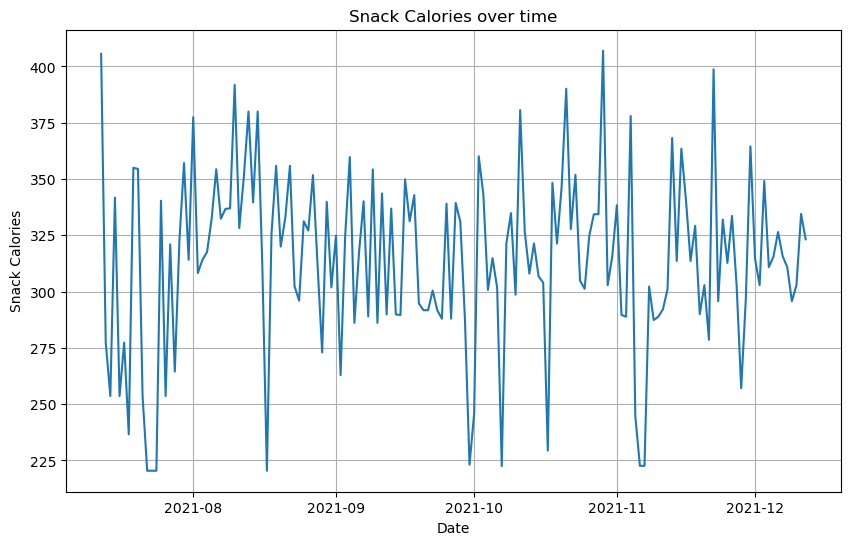

In [75]:
# extract the time_step and calories columns
time_step = df['date'].values  
calories = df['snack_calories'].values  

# convert to numpy arrays
time = np.array(time_step)
series = np.array(calories)

# preview the data
plot_series(time, series, title='Snack Calories over time', xlabel='Date', ylabel='Snack Calories')

## Split Dataset

In [76]:
# Define the split time
split_time = int(df.shape[0] * 0.9)

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepared Features and Labels

In [77]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size)
    
    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)
    
    return dataset

In [78]:
# Parameters
window_size = 7
batch_size = 32
shuffle_buffer_size = 154

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

## Build the Model

In [79]:
# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,1)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                        strides=1,
                        activation="relu",
                        padding='causal'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

# Print the model summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 64)             256       
                                                                 
 bidirectional (Bidirectiona  (None, 7, 256)           197632    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 7, 256)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 30)                3870      
                                                                 
 dense_1 (Dense)             (None, 10)                3

## Tune the Learning Rate

In [80]:
# Get initial weights
init_weights = model.get_weights()

In [81]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


5/5 [==============================] - 8s 32ms/step - loss: 333.8086 - lr: 1.0000e-08
Epoch 2/100
5/5 [==============================] - 0s 24ms/step - loss: 332.5523 - lr: 1.1220e-08
Epoch 3/100
5/5 [==============================] - 0s 37ms/step - loss: 330.0472 - lr: 1.2589e-08
Epoch 4/100
5/5 [==============================] - 0s 40ms/step - loss: 332.4180 - lr: 1.4125e-08
Epoch 5/100
5/5 [==============================] - 0s 29ms/step - loss: 333.6106 - lr: 1.5849e-08
Epoch 6/100
5/5 [==============================] - 0s 27ms/step - loss: 331.2815 - lr: 1.7783e-08
Epoch 7/100
5/5 [==============================] - 0s 27ms/step - loss: 332.9832 - lr: 1.9953e-08
Epoch 8/100
5/5 [==============================] - 0s 28ms/step - loss: 333.6225 - lr: 2.2387e-08
Epoch 9/100
5/5 [==============================] - 0s 26ms/step - loss: 334.9583 - lr: 2.5119e-08
Epoch 10/100
5/5 [==============================] - 0s 29ms/step - loss: 333.4314 - lr: 2.8184e-08
Epoch 11/100
5/5 [=============

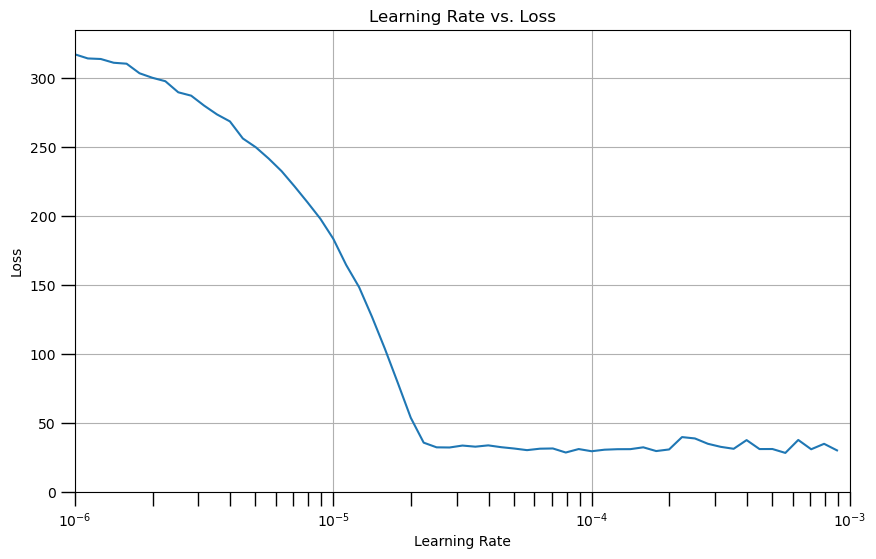

In [82]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-6, 1e-3, 0, max(history.history["loss"])])

# Set the title and labels
plt.title('Learning Rate vs. Loss')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')

# Show the plot
plt.show()

## Train the Model

In [83]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [84]:
# Set the learning rate
learning_rate = 1e-4

# Set the optimizer 
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])

In [85]:
# # Add early stopping if no improvement in validation loss after 50 epochs
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor="val_loss", patience=500, restore_best_weights=True
# )

# # Add learning rate reduction if no improvement in validation loss after 5 epochs
# lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor="val_loss", factor=0.5, patience=50, min_lr=1e-6, verbose=1
# )

# Train the model
history = model.fit(train_set, validation_data=valid_set, epochs=1000)

Epoch 1/1000
5/5 [==============================] - 10s 503ms/step - loss: 279.5640 - mape: 88.6348 - val_loss: 196.2046 - val_mape: 62.3730
Epoch 2/1000
5/5 [==============================] - 0s 39ms/step - loss: 164.8699 - mape: 51.5703 - val_loss: 93.1754 - val_mape: 29.6353
Epoch 3/1000
5/5 [==============================] - 0s 39ms/step - loss: 71.8170 - mape: 22.1526 - val_loss: 9.6726 - val_mape: 3.2960
Epoch 4/1000
5/5 [==============================] - 0s 42ms/step - loss: 37.3758 - mape: 13.2666 - val_loss: 55.9511 - val_mape: 18.0620
Epoch 5/1000
5/5 [==============================] - 0s 41ms/step - loss: 49.3301 - mape: 17.5693 - val_loss: 29.4971 - val_mape: 9.6549
Epoch 6/1000
5/5 [==============================] - 0s 44ms/step - loss: 32.8383 - mape: 11.5773 - val_loss: 10.5329 - val_mape: 3.4586
Epoch 7/1000
5/5 [==============================] - 0s 39ms/step - loss: 33.9052 - mape: 11.1739 - val_loss: 13.2231 - val_mape: 4.2823
Epoch 8/1000
5/5 [=======================

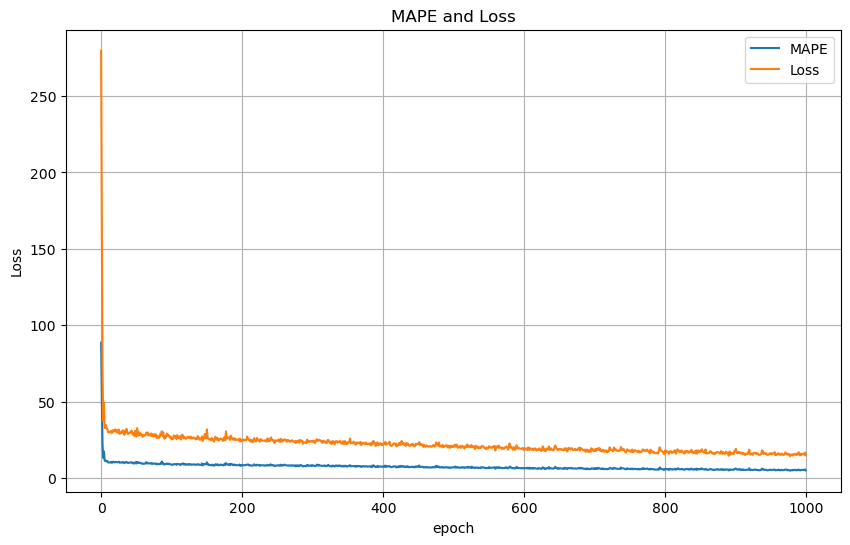

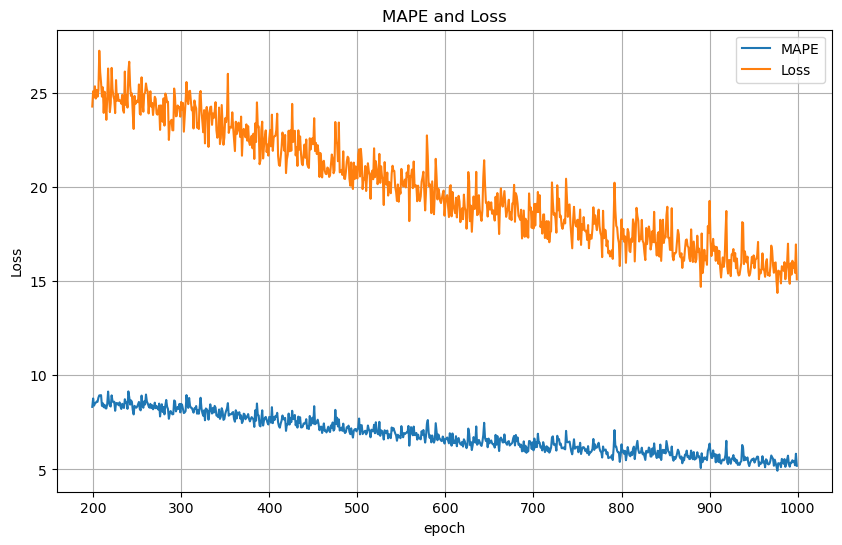

In [86]:
# Get mae and loss from history log
mape=history.history['mape']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mape and loss
plot_series(
    x=epochs, 
    y=(mape, loss), 
    title='MAPE and Loss', 
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAPE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mape_zoom = mape[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mape_zoom, loss_zoom), 
    title='MAPE and Loss', 
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAPE', 'Loss']
    )

## Model Prediction

In [87]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset, verbose=0)
    
    return forecast

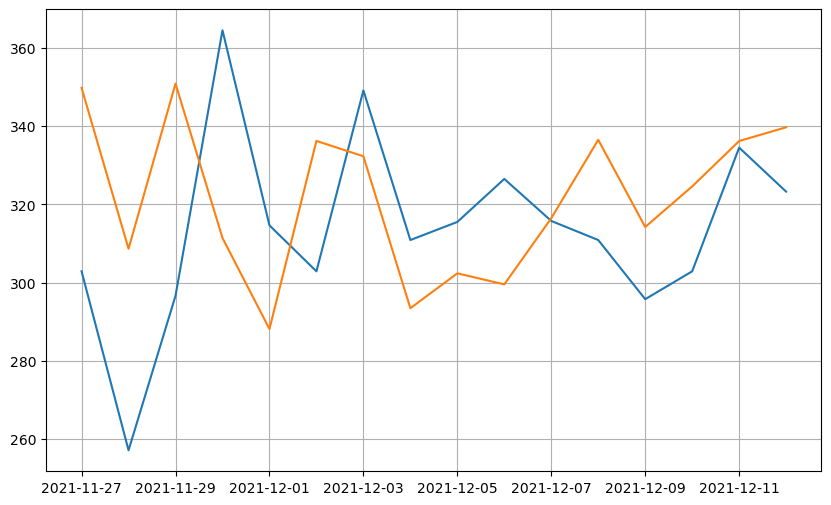

In [88]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

## Model Evaluation 

In [89]:
# Evaluate the model
model.evaluate(valid_set)

1/1 [==============================] - 0s 175ms/step - loss: 15.3021 - mape: 5.0556


[15.30213451385498, 5.055603981018066]

## Forecast

In [90]:
# Generate forecast for the next day
last_window = series[-window_size:]
last_window = last_window.reshape((1, window_size, 1))
next_day_forecast = model.predict(last_window)[0][0]

print(f"Forecast calories intake for the next day: {next_day_forecast} kcal")



1/1 [==============================] - 2s 2s/step
Forecast calories intake for the next day: 350.5520324707031 kcal


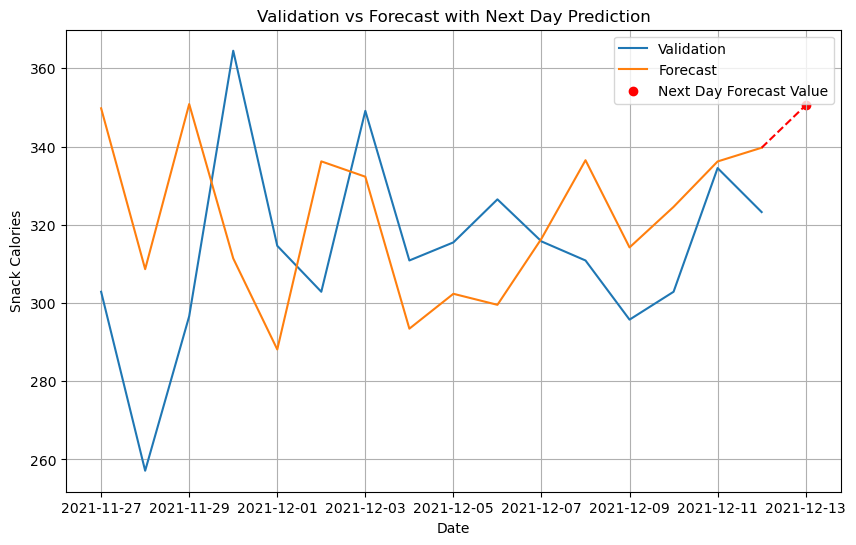

In [91]:
# Plot the forecast for the next day
plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid, label='Validation')
plt.plot(time_valid, results, label='Forecast')
plt.scatter(time_valid[-1] + np.timedelta64(1, 'D'), next_day_forecast, color='r', label='Next Day Forecast Value')
plt.plot([time_valid[-1], time_valid[-1] + np.timedelta64(1, 'D')], [results[-1], next_day_forecast], 'r--')
plt.xlabel('Date')
plt.ylabel('Snack Calories')
plt.title('Validation vs Forecast with Next Day Prediction')
plt.legend()
plt.grid(True)
plt.show()

In [93]:
# Save the model
model.save('calories_fitbit_model_optmz.h5')